<a href="https://colab.research.google.com/github/Zakcrust/Clustering-DataMining/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ALGORITMA DECISION TREE PADA CLASSIFICATION UNTUK MENENTUKAN JENIS KELAMIN BERDASARKAN REKAMAN SUARA

Siapkan Library-library yang akan digunakan

In [ ]:
import pandas as pd
import numpy as np
from sklearn import tree
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from IPython.display import Image


Ambil data dari file csv yang telah disimpan pada url berikut. lalu file tersebut disimpan dalam bentuk Dataframe

In [ ]:
url = 'https://raw.githubusercontent.com/Zakcrust/Clustering-DataMining/main/voice.csv'
df = pandas.read_csv(url)
df.fillna(value=0,axis=1,inplace=True)
features = df.columns
features = features[:19]
df



,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,0.200836,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,0.013683,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,0.008006,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,0.212202,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


Menentukan kolom X dan Kolom Y, kolom X berisikan dari isi data yang akan diolah sedangkan Kolom Y berisikan label data yang menandai suatu baris data

Kami menggunakan Cross Validation untuk mencari nilai kedalaman pohon yang optimal pada Algoritma decision tree yang akan digunakan. sehingga hasil tidak akan menjadi overfitting

Kedalaman pohon terbaik dinilai dari nilai akurasi dari tiap level kedalaman yang jadikan percobaan. Kedalaman pohon yang memiliki nilai akurasi tertinggi akan diambil sebagai nilai kedalaman pohon optimal. Disini kami mencoba dari kedalaman 1 sampai dengan kedalaman 24

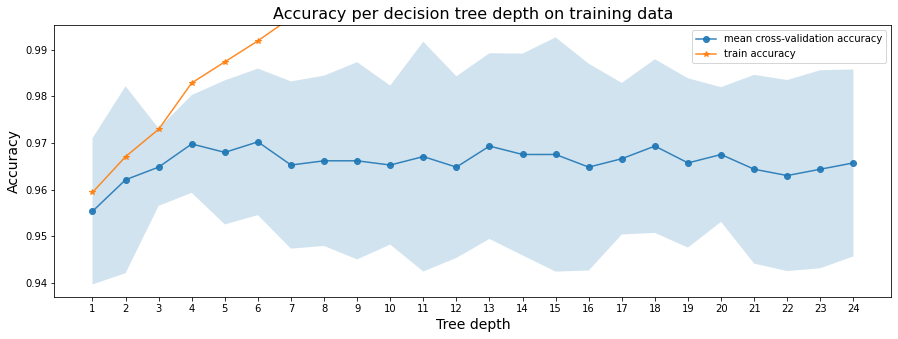

In [ ]:
X = df.values[:, :19]
Y = df.values[:, 20]

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, Y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 100)

Nilai kedalaman yang paling optimal dari hasil metode Cross Validation yang telah dilakukan akan ditampilkan. disini ditemukan bahwa pohon dengan nilai kedalaman 6 menghasilkan nilai rata rata Cross Validation terbaik

In [ ]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))


The depth-6 tree achieves the best mean cross-validation accuracy 97.02316 +/- 0.78506% on training dataset


Dilakukan percobaan untuk menjalankan satu pohon dengan basis data Train dan data Test. fungsi ini menghasilkan nilai akurasi data dari masing masing percobaan

In [ ]:
# function for training and evaluating a tree
def run_single_tree(X_train, y_train, X_test, y_test, depth):
    model = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    print('Single tree depth: ', depth)
    print('Accuracy, Training Set: ', round(accuracy_train*100,5), '%')
    print('Accuracy, Test Set: ', round(accuracy_test*100,5), '%')
    return accuracy_train, accuracy_test, model
  

# train and evaluate a 6-depth tree
sm_best_tree_accuracy_train, sm_best_tree_accuracy_test, ds_model = run_single_tree(X_train, Y_train, 
                                                                          X_test, Y_test, 
                                                                          sm_best_tree_depth)



Single tree depth:  6
Accuracy, Training Set:  99.18809 %
Accuracy, Test Set:  95.89905 %


Data pohon yang sudah dihasilkan oleh fungsi diatas divisualisasikan seperti gambar dibawah ini

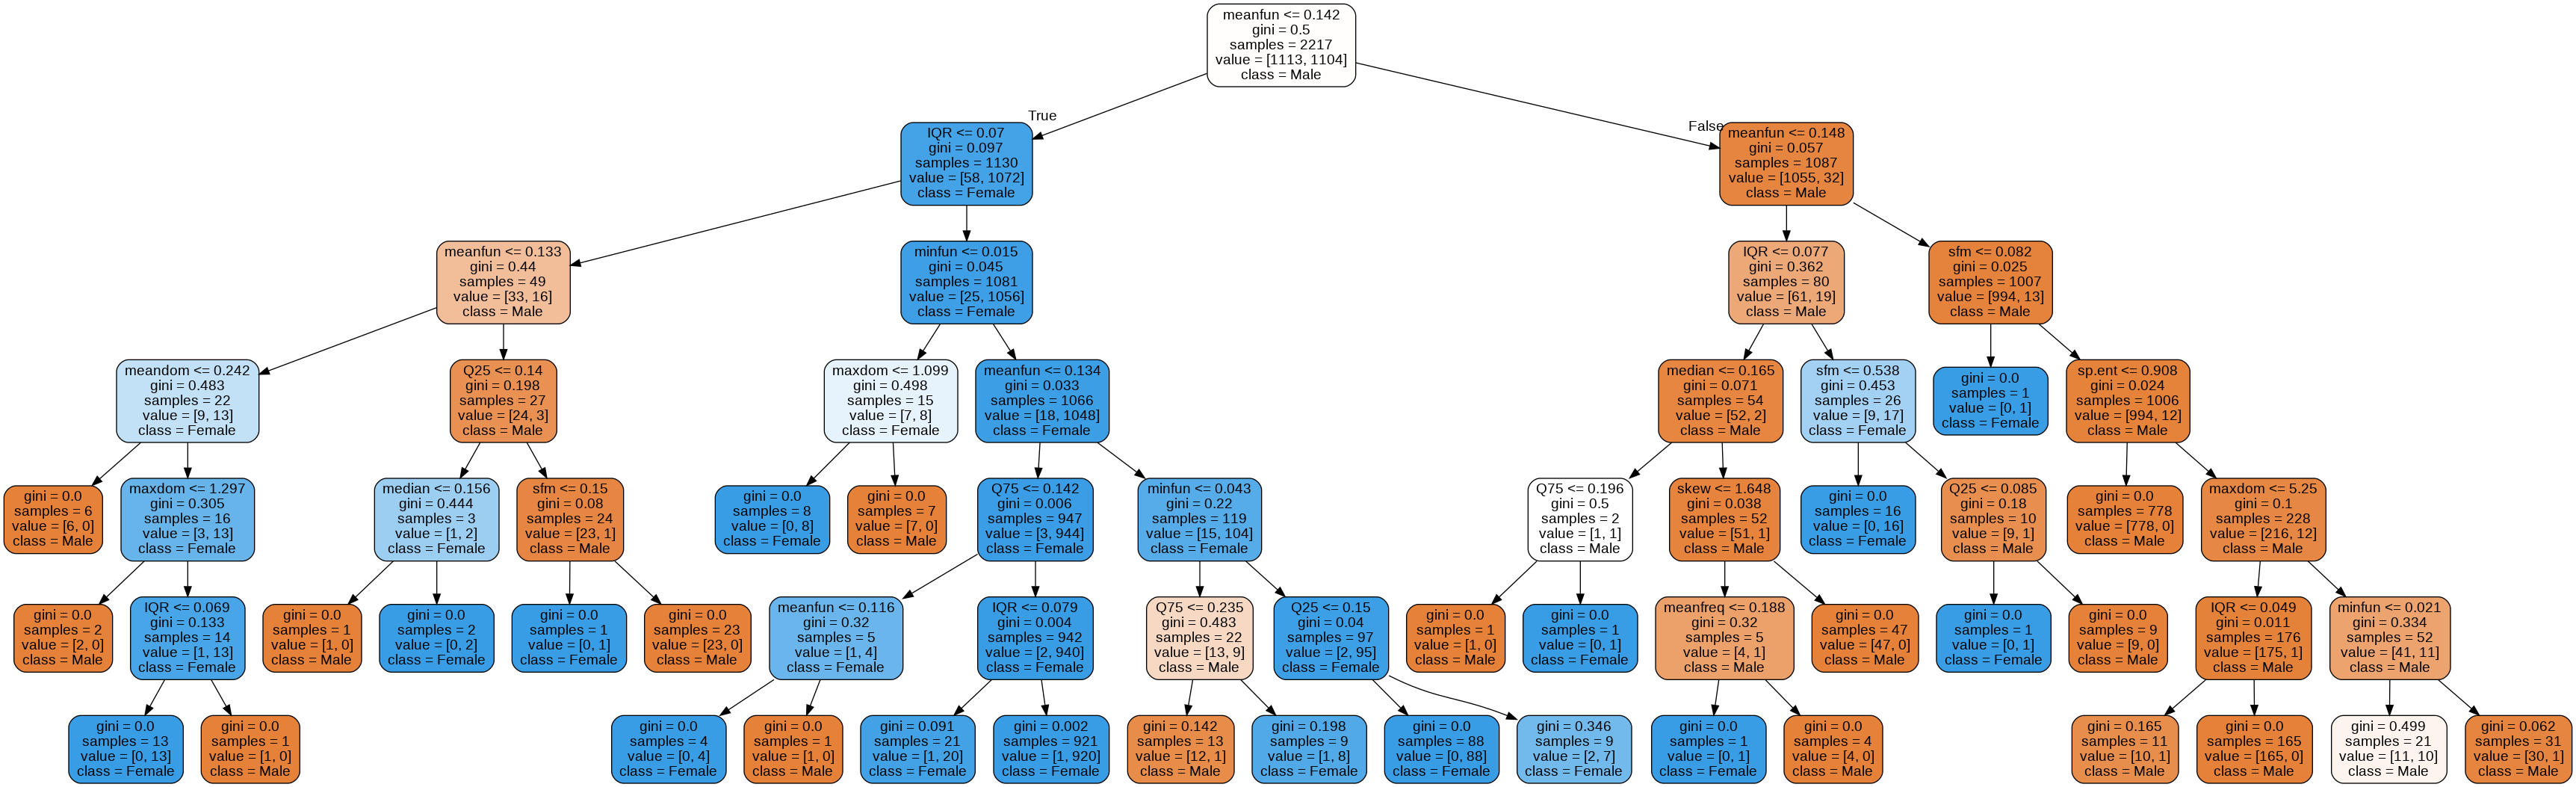

In [ ]:
dot_data = export_graphviz(
            ds_model,
            out_file = None,
            feature_names = features,
            class_names = ['Male', 'Female'],
            rounded = True,
            filled = True)
        
graph = pydotplus.graph_from_dot_data(dot_data)
        
Image(graph.create_png())